## Introducción. Machine Learning
En este notebook se proporcionan algunas utilidades básicas sobre análisis de datos y transformación de variables.
Debe servir como recordatorio a lo que ya se conoce de otros módulos
La librería básica en este módulo de machine learning es scikit-learn/sklearn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

In [2]:
#fijar la semilla de aleatorización
seed = 12345

In [3]:
#leer y convertir a dataframe el archivo de trabajo, en este caso, TITANIC
data = pd.read_excel( "/Users/luiscarrillo/Library/CloudStorage/OneDrive-Personal/Desktop/GitHub/DataScience/MachineLearning/Datasets/titanic.xlsx")
data = data.drop(data.columns[0], axis=1) #eliminamos la primera columna que no tiene sentido

print(f'Número de filas: {data.shape[0]}, Número de columnas:{data.shape[1]}') 
data.head()
data.dtypes

Número de filas: 891, Número de columnas:13


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Title           object
dtype: object

## Paso 1: análisis de datos perdidos

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Title            0
dtype: int64


<Axes: >

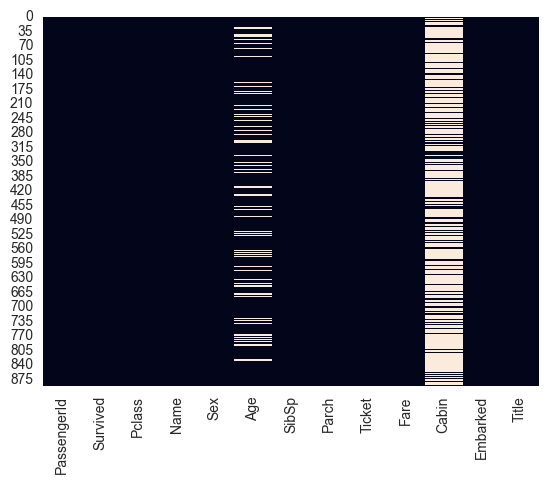

In [4]:
## Paso 1 ## Missing: vemos cuántos missing tiene en cada variable
print(data.isnull().sum())

import seaborn as sns
# Identificamos los missing values visualmente
sns.heatmap(data.isnull(), cbar=False)
## vemos que edad, cabin y Embarked tienen valores perdidos. 
#En concreto, Cabin tiene muchos valores perdidos
#si se quiere imputar por la media. Hay muchas otras opciones
## df.fillna(df.mean(), inplace=True) 

## Paso 2: codificacion, imputación, o eliminacion de datos perdidos
En ocasiones la información relevante es saber si se ha perdido un dato o no
En otros casos merece la pena imputar su valor mientras que otras veces merece la pena eliminarlo, por observaciones o por variables

In [5]:
## 2.1 Modificacion de la variable Cabin
#Se llenan los valores nulos (NaN) de la columna 'Cabin' de data con el valor 0.
data['Cabin'] = data['Cabin'].fillna(0)
#Nueva columna hasCabin, que toma valores binarios 0 y 1, en función de si el pasajero tiene o no un número de cabina.
# La función lambda define que si el valor de "Cabin" es 0 el valor de la columna hasCabin toma valor 0, 
# en caso contrario toma  valor 1.
data['hasCabin'] = data['Cabin'].apply(lambda x: 0 if x==0 else 1)

#Se eliminan variables no relevantes 'PassengerId', 'Name', 'Cabin', 'Ticket'
data = data.drop(columns=['PassengerId', 'Name', 'Cabin', 'Ticket'])

#se asigna nombre a las variables
key_cols = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title', 'hasCabin']

data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,hasCabin
0,0,3,male,22.0,1,0,7.2500,S,Mr,0
1,1,1,female,38.0,1,0,71.2833,C,Mrs,1
2,1,3,female,26.0,0,0,7.9250,S,Miss,0
3,1,1,female,35.0,1,0,53.1000,S,Mrs,1
4,0,3,male,35.0,0,0,8.0500,S,Mr,0


A continuación se muestran algunas de las modificaciones que se podrían aplicar a la base de datos antes de abordar problemas de machine learning (o cualquier otro)

In [6]:
#Modificar las variables Title, Parch y SibSp
#Title tome solo los valores Mr, Mrs, Miss y Otros; 
# Parch y SibSp toman solo los valores 0, 1 o 2 (donde 2 incluye 2 o más)
data['SibSp'] = data.SibSp.apply(lambda x: 2 if x>=2 else x)
data['Parch'] = data.Parch.apply(lambda x: 2 if x>=2 else x)
# La función lambda define que si el valor de "Title" es uno de estos tres ['Mr','Mrs','Miss'],
# se mantendrá el valor original. De lo contrario, se reemplazará con el valor "Otros".
data['Title'] = data.Title.apply(lambda x: x if x in ['Mr','Mrs','Miss'] else 'Otros')

In [7]:
#como Embarked tiene pocos valores nulos (NaN), se eliminan las filas que los contienen
data = data[~data.Embarked.isnull()]
# Se eliminan todos los duplicados.
data = data.drop_duplicates(inplace=False)

In [8]:
# 2.2 imputacion de datos perdidos
imputer = KNNImputer(n_neighbors=3, metric='nan_euclidean')
# Imputamos los valores perdidos en el DataFrame 
## Para imputar con Knn necesitamos tranformar las variables en numeros
le = LabelEncoder()
# Codificamos las variables categóricas como numéricas para poder imputar valores perdidos
data_enco=data

for col in data_enco.columns:
    if data_enco[col].dtype == 'object':  # Si la columna contiene valores categóricos
        le = LabelEncoder()         # Creamos una instancia de LabelEncoder
        data_enco[col] = le.fit_transform(data_enco[col])  # Codificamos la columna como numérica

## ahora podemos inputar por ejemplo con el KNN
data_imputed = pd.DataFrame(imputer.fit_transform(data_enco))
## recuperamos los nombres y tenemos  nuestra base de datos depurada
#es decir, se deshace la codificación a numérico que se había hecho para poder hacer la imputación
data_imputed=data_imputed.set_axis([key_cols], axis=1)

## Pipeline (scikit-learn)
Secuencia de pasos ordenados y automatizados que se utilizan para procesar y analizar datos, entrenar modelos y realizar predicciones. Un pipeline ayuda a organizar y estructurar el flujo de trabajo, lo que facilita la reproducción y el mantenimiento de los procesos.

1. Adquisición de datos: Obtención de datos desde diversas fuentes.
2. Preprocesamiento de datos: Limpieza y transformación de datos para que sean adecuados para el análisis.
3. Exploración y análisis exploratorio de datos: Exploración de datos para comprender patrones, distribuciones y relaciones.
4. Selección y extracción de características: Identificación y extracción de las características más relevantes para el modelado.
5. División de datos: Separación de datos en conjuntos de entrenamiento y prueba.
6. Entrenamiento del modelo: Aplicación de algoritmos de aprendizaje automático para aprender patrones y relaciones en los datos de entrenamiento.
7. Validación y ajuste de hiperparámetros: Evaluación del rendimiento del modelo y ajuste de los parámetros para optimizar su desempeño.
8. Evaluación del modelo: Evaluación del modelo en datos de prueba para medir su capacidad de generalización.
9. Despliegue del modelo: Implementación del modelo en un entorno de producción.

Como se puede ver en ese flujo de trabajo, el pipeline permite hacer una puesta en producción completa end-to-end, incluyendo desde la adquisición de datos hasta el uso del modelo.
En esta parte del módulo se presentan muy superficialmente. Su uso compelto incluyendo el proceso de entrenamiento y test de los modelos de machine learning se incluye en la última parte del módulo

In [9]:
#ColumnTransformer: aplica diferentes transformaciones a diferentes columnas de data y 
#generar un nuevo DataFrame "Transformed data"
#transformer1 aplicará todos lo cambios definidos para cada una de las variables.
transformer1 = [
    ('KNNImputer', KNNImputer(n_neighbors=5,  weights='uniform', metric='nan_euclidean'), ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
    ('PowerTransformerYJ', PowerTransformer(method='yeo-johnson'), ['Fare']),
    ('encoder1', OneHotEncoder(drop='if_binary'), ['Sex']),
    ('encoder2', OneHotEncoder(drop='first'), ['Embarked']),
    ('encoder3', OneHotEncoder(), ['Title']),
    ('encoder4', OneHotEncoder(), ['Parch'])
]

transformer2= [
    ('KNNImputer', KNNImputer(n_neighbors=5,  weights='uniform', metric='nan_euclidean'), ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']),
    
]
#se aplica el transformer1 a los datos
#se utiliza para especificar cómo deben ser tratadas las columnas que no se han mencionado explícitamente en el constructor
#remainder=drop elimina las columnas no especificadas
#remainder=passthrough (predeterminado) no hace nada a las columnas no especificadas pero las mantiene

col_transformer = ColumnTransformer(transformer2, remainder='drop')
#Aplica las transformaciones definidas por col_transformer al conjunto de datos 'data'
ctransformed = col_transformer.fit_transform(data)

- KNNImputer: técnica de imputación de valores faltantes que utiliza el algoritmo de los k vecinos más cercanos. Se usa para estimar los valores faltantes basándose en los valores de las columnas cercanas. 
- PowerTransformer: transforma las variables numéricas con el objetivo de mejorar la distribución y normalidad de los datos.
- OneHotEncoder: transformar una variable categórica  en una representación numérica binaria.

## NOTA IMPORTANTE: AQUÍ SÓLO SE MUESTRA EL CÓDIGO NECESARIO PARA APLICAR RANDOM FOREST.

## RECUÉRDESE LA IMPORTANCIA DE LOS PASOS A SEGUIR PARA IMPLEMENTAR DE FORMA ADECUADA UN MODELO:
 1. CARGAR BASE DE DATOS Y CONOCER FRECUENCIA DE CLASES O DISTRIBUCIÓN DE ACUERDO CON EL TIPO DE PROBLEMA.
 2. DIVIR TRAIN, TEST Y COMPROBAR SI LA DISTRIBUCIÓN DE LA VARIABLE DEPENDIENTE ES SIMILAR EN AMBOS SETS.
 3. AJUSTAR EL MODELO Y VALORAR LAS NECESIDADES DE INVESTIGACIÓN PARA DAR MÁS PESO A UNAS MEDIDAS DE BONDAD DE AJUSTE CON RESPECTO A OTRAS.
 4. HACER PREDICCIONES SOBRE TRAIN Y TEST CON EL FIN DE OBSERVAR EL POSIBLE SOBREAJUSTE. VALORAR EN TEST LA CAPACIDAD PREDICTIVA DEL MODELO.
 5. HACER VALIDACIÓN CRUZADA (Y, EN CASO DE NECESIDAD, SEARCHGRID CON VARIOS PARÁMETROS.)
 6. SELECCIONAR LAS ALTERNATIVAS QUE MÁS NOS INTERESEN POR SU BONDAD DE AJUSTE ESPECÍFICA.
 7. MOSTRAR BOXPLOTS DE SU PERFORMANCE EN LAS DISTINTAS VALIDACIONES PARA VALORAR LA ROBUSTEZ Y TOMAR UNA DECISIÓN.
 8. HACER UN INFORME DE LA PARAMETRIZACIÓN Y BONDAD DE AJUSTE DEL MODELO FINAL SELECCIONADO.